# cuML in primerjava s scikit-learn

V tej enoti se boste seznanili s knjižnico cuML (CUDA Machine Learning), ki je del ogrodja NVIDIA RAPIDS in je namenjena pospeševanju algoritmov strojnega učenja. Preizkusili boste delovanje nekaterih najpogostejših algoritmov strojnega učenja, pri čemer boste uporabljali velike podatkovne zbirke (velepodatke). Knjižnica cuML izvaja algoritme strojnega učenja na grafičnih procesnih enotah (GPE) in tako omogoča pospeševanje teh algoritmov. Pohitritev izvajanja algoritmov strojnega učenja boste preverili s primerjavo izvedbe na centralni procesorski enoti (CPE). To boste storili s pomočjo knjižnice scikit-learn. Kot boste videli v nadaljevanju je priprava učne in testne množice enaka, zelo podobna pa je tudi koda za izvedbo algoritmov strojnega učenja. Torej, če ste že vajeni uporabljati algoritme strojnega učenja na CPE s knjižnico scikit-learn, so potrebne le minimalne spremembe v kodi in algoritem se lahko s cuML izvaja hitreje na GPE.

V nadaljevanju boste podrobneje analizirali uporabo in hitrost izvajanja naslednjih algoritmov strojnega učenja:

* Random forest
* K-Means
* DBSCAN

**Preden začnemo, izvedite spodnjo celico, ki vam namesti ogrodje NVIDIA RAPIDS v okolje Google Colab.**

In [6]:
!rm -rf scripts
!rm -rf rapids-csp-utils
!mkdir scripts

install_script = """
#/bin/bash

echo "Installing NVIDIA RAPIDS to Google Colab ..."

# Check GPU
echo "Checking GPU ..."
nvidia-smi

# Clone Git repository
echo 'Cloning NVIDIA RAPIDS Git repository (https://github.com/rapidsai/rapidsai-csp-utils.git)...'
rm -rf rapidsai-csp-utils
git clone https://github.com/rapidsai/rapidsai-csp-utils.git

# Install using pip
echo 'Installing NVIDIA RAPIDS using pip ...'
python /content/rapidsai-csp-utils/colab/pip-install.py

# Post-install check
echo "Checking NVIDIA RAPIDS installation ..."
python /content/scripts/post-install-check.py
"""

post_install_script = """
import cudf
import cuml
import cugraph
import cuspatial
import cuxfilter

print(f\'cuDF: {cudf.__version__}\\ncuML: {cuml.__version__}\\ncuGraph: {cugraph.__version__}\\ncuSpatial: {cuspatial.__version__}\\ncuxfilter: {cuxfilter.__version__}\')
"""

!echo "{install_script}" >> ./scripts/install-rapids-colab.sh
!echo "{post_install_script}" >> ./scripts/post-install-check.py

!bash scripts/install-rapids-colab.sh

Installing NVIDIA RAPIDS to Google Colab ...
Checking GPU ...
Fri Mar 28 11:02:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |          

## Podprti algoritmi strojnega učenja

cuML podpira različne algoritme strojnega učenja, pri tem pa podpira veliko večino algoritmov, ki so del knjižnice scikit-learn. S cuML lahko na GPE izvajamo:

* [Postopke predobdelave podatkov, izračun metrik in druge uporabne operacije](https://docs.rapids.ai/api/cuml/stable/api/#preprocessing-metrics-and-utilities)
* [Algoritme za regresijo in klasifikacijo](https://docs.rapids.ai/api/cuml/stable/api/#regression-and-classification) *(npr. linearna regresija, Random forest in naivni Bayes)*
* [Algoritme za gručenje](https://docs.rapids.ai/api/cuml/stable/api/#clustering) *(npr. K-Means in DBSCAN)*
* [Postopke za redukcijo dimenzij](https://docs.rapids.ai/api/cuml/stable/api/#dimensionality-reduction-and-manifold-learning) *(npr. PCA, t-SNE in UMAP)*
* [Algoritme, ki upoštevajo sosedstvo](https://docs.rapids.ai/api/cuml/stable/api/#neighbors) *(npr. k-NN)*
* [Algoritme za časovne vrste](https://docs.rapids.ai/api/cuml/stable/api/#time-series) *(npr. Holt-Winters in ARIMA)*
* [Algoritme razložljive umetne inteligence](https://docs.rapids.ai/api/cuml/stable/api/#model-explainability) *(npr. SHAP)*


Čeprav je cuML knjižnica, ki primarno izvaja algoritme na GPE, obstaja za nekatere izbrane algoritme podpora izbire procesorske enote (CPE ali GPE). Pričakovati je, da bodo sčasoma podprti vsi algoritmi v knjižnici cuML, trenutno podprte algoritme pa lahko preverimo v [dokumentaciji](https://docs.rapids.ai/api/cuml/stable/api/#cpu-gpu-device-selection-experimental).

## Namestitev knjižnice scikit-learn

V naslednjih sekcijah boste primerjali delovanje algoritmov strojnega učenja na GPE in CPE. Na GPE boste algoritme izvajali s cuML, na CPE pa s knjižnico scikit-learn. Najprej namestimo knjižnico scikit-learn.

In [7]:
!pip install scikit-learn

In [8]:
import sklearn
print(f"scikit-learn: {sklearn.__version__}")

scikit-learn: 1.6.1


## Random forest

V tem delu enote boste preizkusili delovanje algoritma Random forest, ki ga boste zagnali nad sintetično velepodatkovno zbirko. Velepodatke boste torej generirali z orodji, ki so del knjižnice scikit-learn (funkcija ``make_classification``). Nato boste velepodatkovno zbirko razdelili na učno in testno množico in zagnali algoritem Random forest na GPE (cuML) in CPE (scikit-learn). Primerjali boste čas izvajanja in klasifikacijsko točnost obeh pristopov.

Najprej vključimo vse knjižnice in pripravimo velepodatkovno zbirko:

In [38]:
from cuml.ensemble import RandomForestClassifier as cuRF # algoritem Random forest (cuML)
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier as skRF # algoritem Random forest (scikit-learn)
import numpy as np

# priprava velepodatkovne zbirke
N_SAMPLES = 2_500_000       # 2.5mio vzorcev
N_FEATURES = 20             # 20 značilk
N_INFORMATIVE = 12          # 12 informativnih značilk
N_CLASSES = 7               # 7 razredov (večrazredna klasifikacija)

# parametri Random forest
N_ESTIMATORS = 25
MAX_DEPTH = 10

**Dodatno:** Za pripravo sintetične velepodatkovne zbirke boste uporabili funkcijo ``make_classification``, ki je del knjižnice scikit-learn (``sklearn.datasets``). Ta funkcija generira podatke na CPE. Če bi želeli generirati podatke na GPE, lahko to naredite s funkcijo [``make_classification``](https://docs.rapids.ai/api/cuml/stable/api/#cuml.datasets.make_classification), ki je del knjižnice cuML (``cuml.datasets.classification``). Parametri in uporaba funkcije ostaneta enaka, le v ozadju se pravzaprav uporabljajo druge knjižnice ogrodja NVIDIA RAPIDS (npr. cuDF in Dask). Če želite, lahko sami preizkusite generiranje sintetične velepodatkovne zbirke kar na GPE.


>```python
>from cuml.ensemble import RandomForestClassifier as cuRF
>from sklearn.model_selection import train_test_split
>from cuml.datasets.classification import make_classification # cuML make_classification
>...
>```

In [40]:
%%time
# ustvarimo velepodatkovno zbirko
X, y = make_classification(n_classes=N_CLASSES, n_features=N_FEATURES, n_informative=N_INFORMATIVE, n_samples=N_SAMPLES, random_state=11)

# pretvorba iz float64 v float32; sicer dobimo opozorilo pri uporabi cuML RF
X = np.float32(X)
y = np.int32(y)

CPU times: user 3.77 s, sys: 254 ms, total: 4.02 s
Wall time: 3.44 s


Ustvarjanje velepodatkovne zbirke je trajalo 3,44s. Kot je razvidno iz zgornje kode, smo vrednosti pretvorili iz tipa ``float64`` v ``float32``. Trenutno knjižnica cuML za izvajanje algoritma Random forest podpira le tip ``float32``. Ročno pretvorbo lahko preskočimo, vendar bo zagon algoritma Random forest (cuML) javil opozorilo. V nadaljevanju razdelimo učno in testno množico v razmerju 70:30. Nato bomo nad učno množico (70%) učili klasifikator, s testno množico (30%) pa bomo preverili kvaliteto naučenega klasifikatorja.

In [41]:
# razdelitev na učno in testno množico
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% učna, 30% testna

In [43]:
%%time
# cuML Random forest

rf_gpu = cuRF(max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS)
model_gpu = rf_gpu.fit(X_train, y_train) # učenje klasifikatorja na GPE

CPU times: user 2.58 s, sys: 1.47 s, total: 4.05 s
Wall time: 2.14 s


Učenje klasifikatorja na GPE je trajalo 2,14s. Poskusimo še z učenjem na CPE in primerjajmo čas učenja ter kvaliteto klasifikatorja.

In [13]:
%%time
# scikit-learn Random forest

rf_cpu = skRF(max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS)
model_cpu = rf_cpu.fit(X_train, y_train)

CPU times: user 4min 19s, sys: 745 ms, total: 4min 19s
Wall time: 4min 25s


Učenje klasifikatorja na CPE je trajalo <u>**4min 25s**</u>, kar je **bistveno počasneje** od učenja na GPE. Poskusimo še z večnitno izvedbo klasifikatorja na CPE z uporabo parametra `n_jobs`.

In [14]:
%%time
# scikit-learn Random forest z večnitnim izvajanjem

rf_cpu = skRF(max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS, n_jobs=-1) # uporaba vseh jeder CPE
model_cpu = rf_cpu.fit(X_train, y_train)

CPU times: user 5min 51s, sys: 1.1 s, total: 5min 52s
Wall time: 3min 20s


Učenje klasifikatorja na CPE z uporabo vseh jeder CPE je trajalo <u>**3min 20s**</u>, kar je sicer hitreje kot z uporabo enega jedra CPE, vender še vedno **bistveno počasneje** od učenja na GPE. Preverimo ali sta kvaliteti klasifikatorjev primerljivi.

In [15]:
preds_gpu = model_gpu.predict(X_test) # testiranje modela cuML
preds_cpu = model_cpu.predict(X_test) # testiranje modela scikit-learn

In [16]:
# izračun metrike točnosti

acc_gpu = accuracy_score(y_test, preds_gpu)
acc_cpu = accuracy_score(y_test, preds_cpu)

print(f'Točnost (GPE) = {acc_gpu:.3f} [cuML]\nTočnost (CPE) = {acc_cpu:.3f} [scikit-learn]')

Točnost (GPE) = 0.747 [cuML]
Točnost (CPE) = 0.743 [scikit-learn]


Točnost za obe procesni enoti sta praktično enaki. Z izvedbo algoritma na GPE smo pridobili na hitrosti, hkrati pa je kvaliteta klasifikatorja ostala primerljiva. Opazimo torej, da se splača uporabljati pospeševanje algoritmov za klasifikacijo s pomočjo GPE.

## K-Means

V tem delu enote boste preizkusili delovanje algoritma K-Means, ki ga boste zagnali nad sintetično velepodatkovno zbirko. Tokrat boste uporabili funkcijo ``make_blobs`` v knjižnici scikit-learn, ki generira sintetične podatke v obliki gruč na CPE. Podobno kot pri generiranju sintetične velepodatkovne zbirke za algoritem Random forest, lahko tudi v tem primeru uporabite funkcijo [``make_blobs``](https://docs.rapids.ai/api/cuml/legacy/api/#dataset-generation-single-gpu) knjižnice cuML, ki generiranje podatkov izvede na GPE. Dodatno lahko generiranje izvajamo na več GPE z uporabo [``make_blobs``](https://docs.rapids.ai/api/cuml/legacy/api/#dataset-generation-dask-based-multi-gpu) knjižnice Dask. Vidimo torej, da za takšen tip operacij ogrodje NVIDIA RAPIDS omogoča skalabilnost in izbiro procesorske enote na zelo enostaven način, ki ne zahteva večjih sprememb v programski kodi.

Ker boste v tem delu enote izvajali gručenje, velepodatkovne zbirke ne bo potrebno razdeliti na učno in testno množico. Pripravimo torej velepodatkovno zbirko in preizkusimo delovanje algoritma K-Means na GPE (cuML) in primerjajmo čas izvajanja ter rezultate z algoritmom K-Means na CPE (scikit-learn):


In [45]:
from cuml.cluster import KMeans as cuKMeans # algoritem K-Means (cuML)
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans as skKMeans # algoritem K-Means (scikit-learn)

# priprava velepodatkovne zbirke
N_SAMPLES = 100000      # 100.000 vzorcev
N_FEATURES = 2          # 2 značilki (2D prostor)

# parametri K-Means
N_CLUSTERS = 5  # želimo 5 gruč
N_INIT = 10

In [46]:
%%time
# ustvarimo velepodatkovno zbirko

X, Y = make_blobs(n_samples=N_SAMPLES, n_features=N_FEATURES, centers=5, random_state=420)

CPU times: user 16.9 ms, sys: 0 ns, total: 16.9 ms
Wall time: 16.3 ms


Pripravili smo velepodatkovno zbirko s 100.000 točkami, ki so porazdeljene v 5 gruč. Gruče točk se lahko tudi deloma prekrivajo. Za lažjo predstavo situacije izrišimo gruče točk. Za to bomo uporabili knjižnico ``matplotlib``.

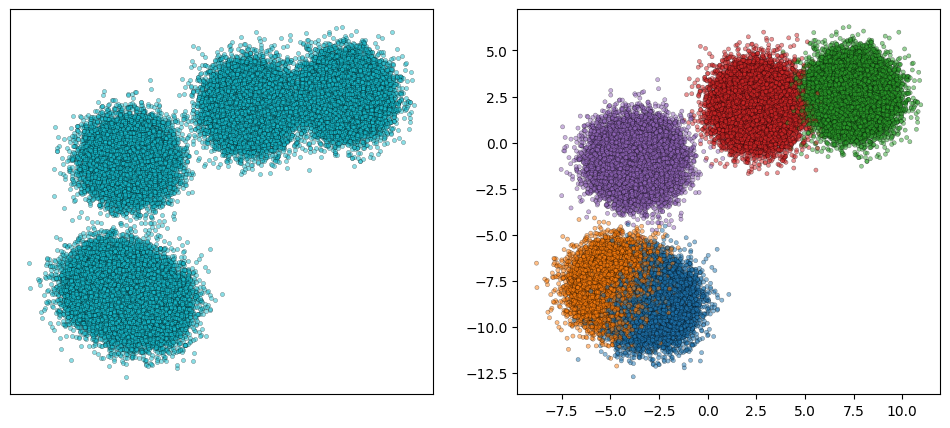

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['tab:purple', 'tab:orange', 'tab:green', 'tab:blue', 'tab:red'])

# vizualizacija točk
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 vrstica, 2 stolpca (side-by-side)
ax[0].scatter(X[:, 0], X[:, 1], marker='.', c='tab:cyan', edgecolor='k', linewidth=0.3, alpha=0.5) # podatkovna množica
ax[1].scatter(X[:, 0], X[:, 1], marker='.', c=Y, edgecolor='k', linewidth=0.3, alpha=0.5, cmap=cmap) # generirane gruče

# odstranimo oznake
for a in ax.flat:
  a.label_outer()
  a.set_xticks([])
  a.set_yticks([])

  plt.show()

Nad temi gručami točk zaženimo algoritem K-Means na GPE. Pričakujemo, da bo algoritem zlahka določil tri zgornje gruče. Pri prekrivajočih spodnjih dveh pričakujemo razdelitev nekje po sredini. Merili bomo čas izvajanja algoritma za primerjavo z zagonom na CPE.

In [55]:
%%time
# cuML K-Means

kmeans_gpu = cuKMeans(n_clusters=N_CLUSTERS, n_init=N_INIT)
kmeans_gpu.fit(X)

CPU times: user 431 ms, sys: 22.9 ms, total: 454 ms
Wall time: 452 ms


KMeans()

Izvajanje algoritma je trajalo 452ms. Preverimo še rezultat tako, da grafično prikažemo pobarvane gruče in njihove centroide.

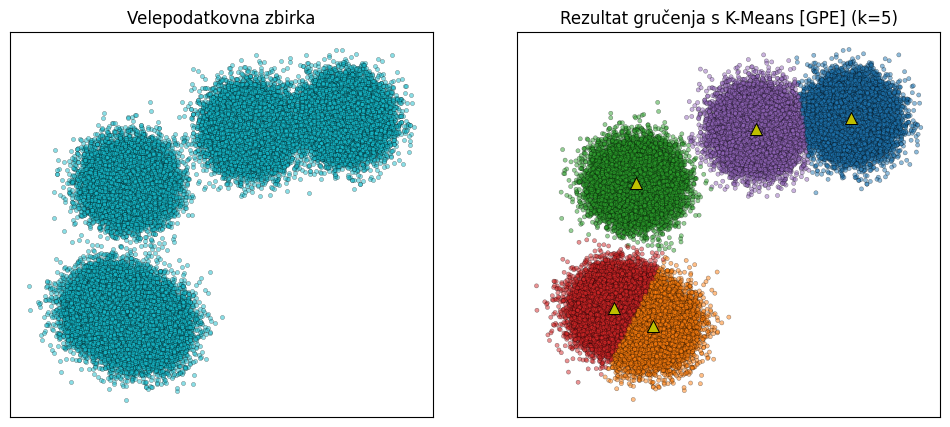

In [56]:
# vizualizacija rezultata
centers_gpu = kmeans_gpu.cluster_centers_
preds_gpu = kmeans_gpu.predict(X)

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 vrstica, 2 stolpca (side-by-side)

# izris točk
ax[0].set_title('Velepodatkovna zbirka')
ax[0].scatter(X[:, 0], X[:, 1], marker='.', c='tab:cyan', edgecolor='k', linewidth=0.3, alpha=0.5)

# izris rezultata gručenja
ax[1].set_title('Rezultat gručenja s K-Means [GPE] (k=5)')
ax[1].scatter(X[:, 0], X[:, 1], marker='.', c=preds_gpu, edgecolor='k', linewidth=0.3, alpha=0.5, cmap=cmap) # gruče
ax[1].scatter(centers_gpu[:, 0], centers_gpu[:, 1], marker='^', c='y', edgecolor='k', linewidth=0.7, s=75) # centroidi

# odstranimo oznake
for a in ax.flat:
  a.label_outer()
  a.set_xticks([])
  a.set_yticks([])

plt.show()

Vidimo, da je algoritem z danimi parametri zelo dobro določil gruče in njihove centroide. Poskusimo še enako z algoritmom K-Means, ki teče na CPE. Uporabili bomo implementacijo v knjižnici scikit-learn.

In [59]:
%%time
# scikit-learn K-Means

kmeans_cpu = skKMeans(n_clusters=N_CLUSTERS, n_init=N_INIT)
kmeans_cpu.fit(X)

CPU times: user 779 ms, sys: 821 µs, total: 780 ms
Wall time: 575 ms


KMeans(n_clusters=5, n_init=10)

Tokrat je izvajanje algoritma trajalo 575ms kar je za približno **100ms počasneje** v primerjavi z izvajanjem na GPE. Bodite pozorni na to, da se programska koda za zagon algoritma ni bistveno spremenila. Ponovno preverimo rezultat z grafičnim prikazom.

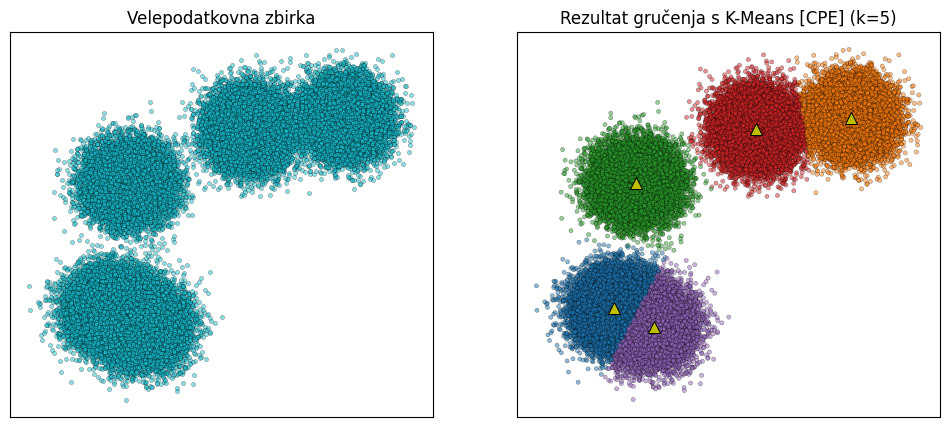

In [60]:
# vizualizacija rezultata
centers_cpu = kmeans_cpu.cluster_centers_
preds_cpu = kmeans_cpu.predict(X)

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 vrstica, 2 stolpca (side-by-side)

# izris točk
ax[0].set_title('Velepodatkovna zbirka')
ax[0].scatter(X[:, 0], X[:, 1], marker='.', c='tab:cyan', edgecolor='k', linewidth=0.3, alpha=0.5)

# izris rezultata gručenja
ax[1].set_title('Rezultat gručenja s K-Means [CPE] (k=5)')
ax[1].scatter(X[:, 0], X[:, 1], marker='.', c=preds_cpu, edgecolor='k', linewidth=0.3, alpha=0.5, cmap=cmap) # gruče
ax[1].scatter(centers_cpu[:, 0], centers_cpu[:, 1], marker='^', c='y', edgecolor='k', linewidth=0.7, s=75) # centroidi

# odstranimo oznake
for a in ax.flat:
  a.label_outer()
  a.set_xticks([])
  a.set_yticks([])

plt.show()

Tudi tokrat smo dosegli zelo dober rezultat. Ker sta rezultata zelo podobna, ju primerjajmo z nekaj metrikami. Na ta način bomo bolje videli razlike med obema rezultatoma in se prepričali o tem ali je morebiti kateri izmed njiju boljši.

In [61]:
# primerjava metrik za gručenje (GPE vs CPE)

# uporaba metrik za oceno kakovosti gručenja
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, v_measure_score, homogeneity_score, completeness_score

# izračun za GPE
ami_gpu = adjusted_mutual_info_score(Y, kmeans_gpu.labels_)
ars_gpu = adjusted_rand_score(Y, kmeans_gpu.labels_)
vms_gpu = v_measure_score(Y, kmeans_gpu.labels_)
hs_gpu = homogeneity_score(Y, kmeans_gpu.labels_)
cs_gpu = completeness_score(Y, kmeans_gpu.labels_)

# izračun za CPE
ami_cpu = adjusted_mutual_info_score(Y, kmeans_cpu.labels_)
ars_cpu = adjusted_rand_score(Y, kmeans_cpu.labels_)
vms_cpu = v_measure_score(Y, kmeans_cpu.labels_)
hs_cpu = homogeneity_score(Y, kmeans_cpu.labels_)
cs_cpu = completeness_score(Y, kmeans_cpu.labels_)

# izpis rezultatov v tabeli (Pandas DataFrame)
import pandas as pd
rows = ['GPE', 'CPE']
cols = ['Adjusted mutual information score', 'Adjusted rand score', 'V-measure score', 'Homogeneity score', 'Completeness score']

df = pd.DataFrame([[ami_gpu, ars_gpu, vms_gpu, hs_gpu, cs_gpu], [ami_cpu, ars_cpu, vms_cpu, hs_cpu, cs_cpu]], rows, cols)
df.style.format(precision=3, decimal=',')
df.head()

,Adjusted mutual information score,Adjusted rand score,V-measure score,Homogeneity score,Completeness score
GPE,0.873407,0.848810,0.873413,0.873413,0.873414
CPE,0.873334,0.848727,0.873341,0.873331,0.873350


Rezultati metrik pokažejo, da sta rezultata bolj ali manj enaka. Naša velepodatkovna zbirka vsebuje dokaj jasno ločene gruče točk. Poskusimo z bolj neenakomerno porazdeljenimi točkami, ki tvorijo neregularne oblike. To lahko dosežemo s funkcijo [``make_moons``](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons), ki generira točke v obliki dveh ločenih polmesecev.

In [62]:
from sklearn.datasets import make_moons

# priprava velepodatkovne zbirke
N_SAMPLES = 50000      # 50000 točk

X, Y = make_moons(n_samples=N_SAMPLES, noise=0.1, random_state=2024)

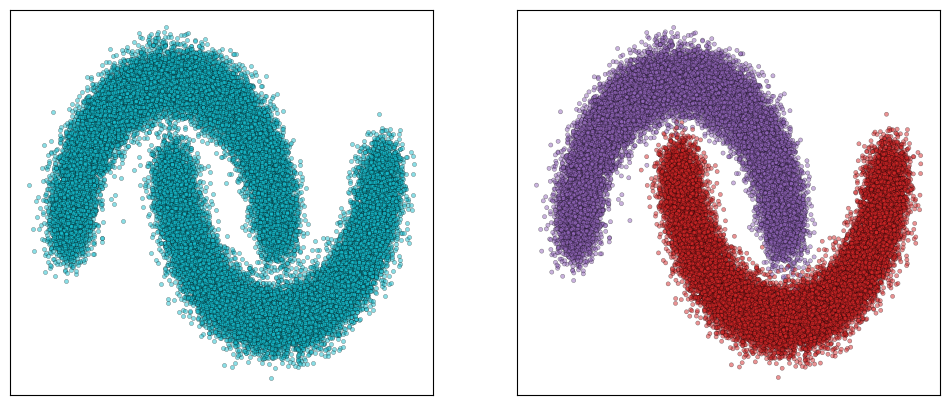

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['tab:purple', 'tab:orange', 'tab:green', 'tab:blue', 'tab:red'])

# vizualizacija točk

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 vrstica, 2 stolpca (side-by-side)
ax[0].scatter(X[:, 0], X[:, 1], marker='.', c='tab:cyan', edgecolor='k', linewidth=0.3, alpha=0.5)
ax[1].scatter(X[:, 0], X[:, 1], marker='.', c=Y, edgecolor='k', linewidth=0.3, alpha=0.5, cmap=cmap)

# odstranimo oznake
for a in ax.flat:
  a.label_outer()
  a.set_xticks([])
  a.set_yticks([])

plt.show()

Poskusimo zagnati algoritem K-Means na tej velepodatkovni zbirki, ki je za ta algoritem zelo problematična.

In [27]:
%%time

# parametri K-Means
N_CLUSTERS = 2 # tokrat imamo samo dve gruči - zgornji in spodnji polmesec
N_INIT = 10

# cuML K-Means
kmeans_gpu = cuKMeans(n_clusters=N_CLUSTERS, n_init=N_INIT)
kmeans_gpu.fit(X)

CPU times: user 215 ms, sys: 22.9 ms, total: 238 ms
Wall time: 239 ms


KMeans()

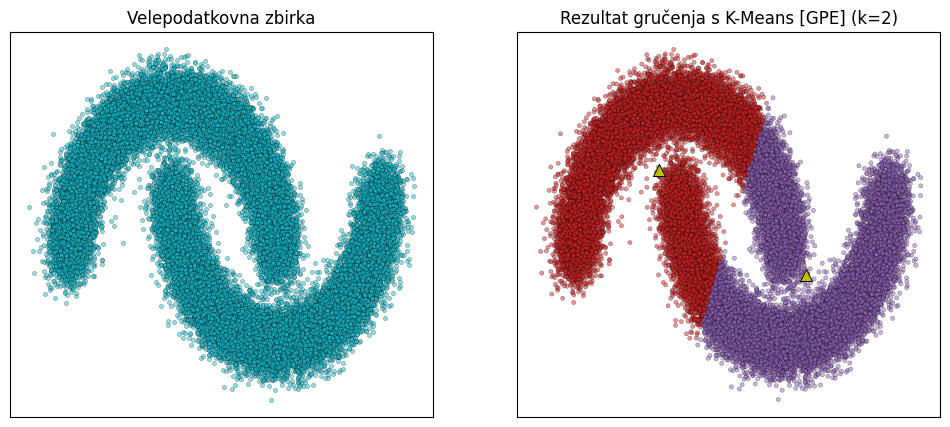

In [28]:
# vizualizacija rezultata
centers_gpu = kmeans_gpu.cluster_centers_
preds_gpu = kmeans_gpu.predict(X)

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 vrstica, 2 stolpca (side-by-side)

# izris točk
ax[0].set_title('Velepodatkovna zbirka')
ax[0].scatter(X[:, 0], X[:, 1], marker='.', c='tab:cyan', edgecolor='k', linewidth=0.3, alpha=0.5)

# izris rezultata gručenja
ax[1].set_title('Rezultat gručenja s K-Means [GPE] (k=2)')
ax[1].scatter(X[:, 0], X[:, 1], marker='.', c=preds_gpu, edgecolor='k', linewidth=0.3, alpha=0.5, cmap=cmap) # gruče
ax[1].scatter(centers_gpu[:, 0], centers_gpu[:, 1], marker='^', c='y', edgecolor='k', linewidth=0.7, s=75) # centroidi

# odstranimo oznake
for a in ax.flat:
  a.label_outer()
  a.set_xticks([])
  a.set_yticks([])

plt.show()

Iz prikaza rezultata je jasno, da z algoritmom K-Means ne dobimo dobrega rezultata gručenja. Poglejmo si torej algoritem DBSCAN, ki nima omejitev K-Means in tako poskusimo priti do boljših rezultatov gručenja.

## DBSCAN

V tem delu enote boste preizkusili delovanje algoritma DBSCAN, ki ga boste zagnali nad sintetično velepodatkovno zbirko. Algoritem DBSCAN se od algoritma K-Means razlikuje v tem, da na vhodu ni potrebno navesti števila gruč (parameter k). Algoritem DBSCAN se izkaže za boljšega kadar so podatki neenakomerno porazdeljeni in imajo neregularne oblike. Uporabimo zgornjo sintetično velepodatkovno zbirko in preizkusimo delovanje algoritma DBSCAN na GPE (cuML) in primerjajmo čas izvajanja ter rezultate z algoritmom DBSCAN na CPE (scikit-learn):


In [29]:
from cuml.cluster import DBSCAN as cuDBSCAN # algoritem DBSCAN (cuML)
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN as skDBSCAN # algoritem DBSCAN (scikit-learn)

# parametri DBSCAN
EPSILON = 0.2
MIN_SAMPLES = 1500

In [30]:
%%time
# cuML DBSCAN

dbscan_gpu = cuDBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(X)
labels_gpu = dbscan_gpu.labels_

[2025-03-28 11:11:25.983] [CUML] [warning] Batch size limited by the chosen integer type (4 bytes). 50000 -> 42949. Using the larger integer type might result in better performance
CPU times: user 1.07 s, sys: 144 ms, total: 1.22 s
Wall time: 1.34 s


Izvajanje algoritma je trajalo 1,34s. Izrišimo rezultat in ovrednotimo kvaliteto gručenja.

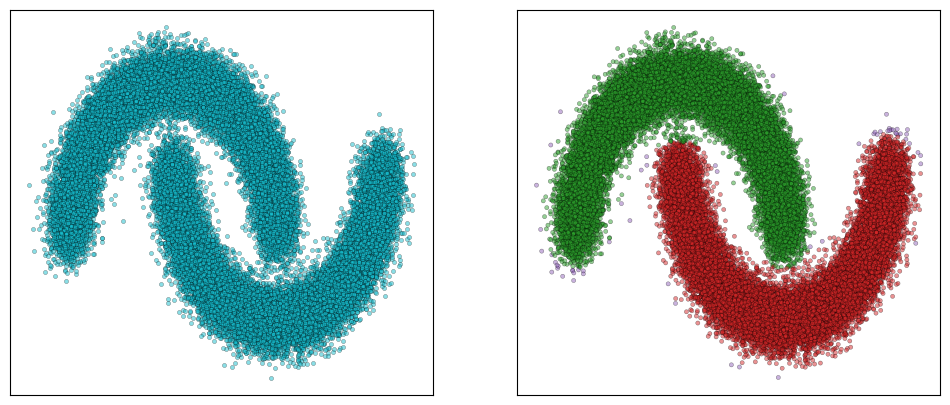

In [31]:
# vizualizacija gručenja

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 vrstica, 2 stolpca (side-by-side)
ax[0].scatter(X[:, 0], X[:, 1], marker='.', c='tab:cyan', edgecolor='k', linewidth=0.3, alpha=0.5)
ax[1].scatter(X[:, 0], X[:, 1], marker='.', c=labels_gpu, edgecolor='k', linewidth=0.3, alpha=0.5, cmap=cmap)

# odstranimo oznake
for a in ax.flat:
  a.label_outer()
  a.set_xticks([])
  a.set_yticks([])

plt.show()

Iz prikaza rezultata je jasno, da je bilo gručenje algoritma DBSCAN uspešno, saj sta oba polmeseca dobro ločena v dve gruči točk. Poskusimo še z izvedbo algoritma DBSCAN na CPE. Pri tem uporabimo eno jedro CPE. To je privzeta nastavitev v implementaciji knjižnice scikit-learn.

In [32]:
%%time
# scikit-learn DBSCAN

dbscan_cpu = skDBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(X) # uporaba enega jedra CPE
labels_cpu = dbscan_cpu.labels_

CPU times: user 2.66 s, sys: 765 ms, total: 3.43 s
Wall time: 3.51 s


Tokrat je izvajanje algoritma trajalo 3,51s kar je približno **trikrat počasneje** v primerjavi z izvedbo na GPE. Ponovno preverimo kvaliteto gručenja z grafično predstavitvijo:

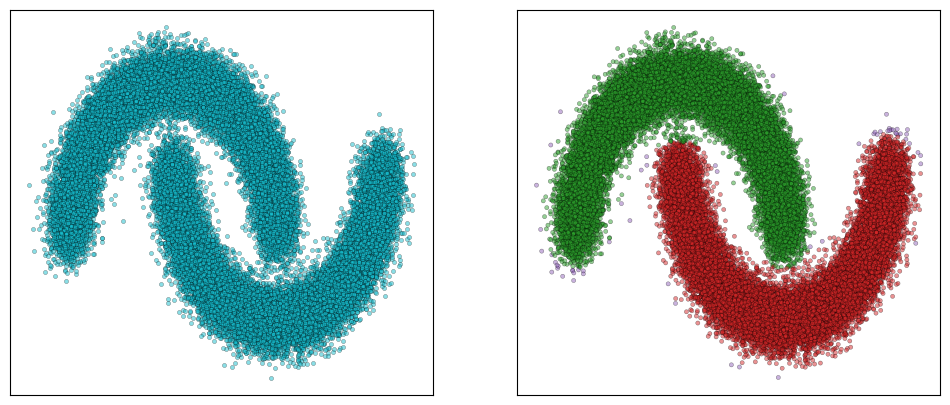

In [33]:
# vizualizacija gručenja

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 vrstica, 2 stolpca (side-by-side)
ax[0].scatter(X[:, 0], X[:, 1], marker='.', c='tab:cyan', edgecolor='k', linewidth=0.3, alpha=0.5)
ax[1].scatter(X[:, 0], X[:, 1], marker='.', c=labels_cpu, edgecolor='k', linewidth=0.3, alpha=0.5, cmap=cmap)

# odstranimo oznake
for a in ax.flat:
  a.label_outer()
  a.set_xticks([])
  a.set_yticks([])

plt.show()

Tudi rezultat tega gručenja je ustrezen in zelo podoben rezultatu izvedbe na GPE. Za konec še poskusimo z izvedbo na CPE, vendar tokrat uporabimo vsa procesorska jedra, ki so na voljo. To storimo s parametrom ``n_jobs``, kateremu nastavimo vrednost na -1.

In [34]:
%%time
# scikit-learn DBSCAN

dbscan_cpu = skDBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES, n_jobs=-1).fit(X) # uporaba vseh jeder CPE
labels_cpu = dbscan_cpu.labels_

CPU times: user 3.37 s, sys: 757 ms, total: 4.13 s
Wall time: 2.4 s


Algoritem DBSCAN se je na vseh jedrih izvajal 2,4s kar je malenkost hitreje v primerjavi z izvedbo na enem jedru, hkrati pa je **ponovno počasneje** v primerjavi z izvedbo na GPE. Izvedba na vseh jedrih je sicer lahko v določenih primerih tudi *počasnejša* od izvedbe na enem jedru zaradi zakasnitev pri združevanju *(ang. aggregation)* porazdeljenih delnih rezultatov. Paralelna obdelava se praviloma splača šele pri dovolj velikih količinah podatkov, kar smo v našem primeru očitno dosegli. Preverimo še rezultat tega gručenja:

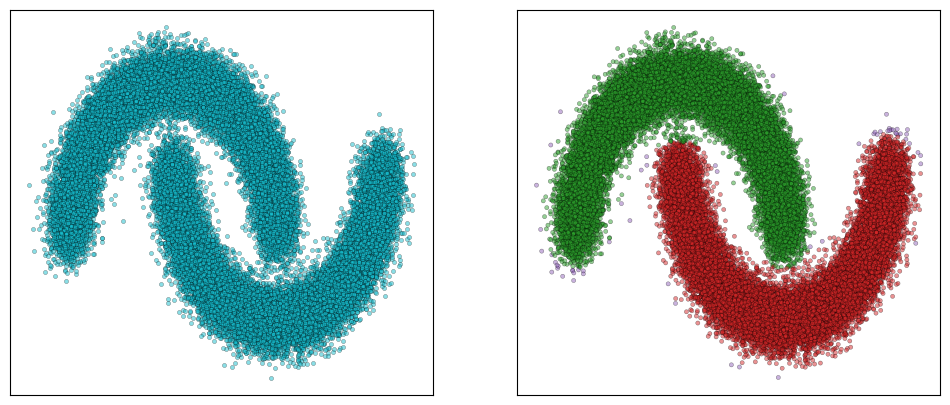

In [35]:
# vizualizacija točk

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 vrstica, 2 stolpca (side-by-side)
ax[0].scatter(X[:, 0], X[:, 1], marker='.', c='tab:cyan', edgecolor='k', linewidth=0.3, alpha=0.5)
ax[1].scatter(X[:, 0], X[:, 1], marker='.', c=labels_gpu, edgecolor='k', linewidth=0.3, alpha=0.5, cmap=cmap)

# odstranimo oznake
for a in ax.flat:
  a.label_outer()
  a.set_xticks([])
  a.set_yticks([])

plt.show()

Vidimo torej, da se pospeševanje na GPE iz časovnega vidika splača, prav tako pa dobimo enako dobre rezultate gručenja. Za konec še slednje potrdimo s primerjavo metrik za gručenje.

In [36]:
# primerjava metrik za gručenje (GPE vs CPE)

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, v_measure_score, homogeneity_score, completeness_score

ami_gpu = adjusted_mutual_info_score(Y, dbscan_gpu.labels_)
ars_gpu = adjusted_rand_score(Y, dbscan_gpu.labels_)
vms_gpu = v_measure_score(Y, dbscan_gpu.labels_)
hs_gpu = homogeneity_score(Y, dbscan_gpu.labels_)
cs_gpu = completeness_score(Y, dbscan_gpu.labels_)

ami_cpu = adjusted_mutual_info_score(Y, dbscan_cpu.labels_)
ars_cpu = adjusted_rand_score(Y, dbscan_cpu.labels_)
vms_cpu = v_measure_score(Y, dbscan_cpu.labels_)
hs_cpu = homogeneity_score(Y, dbscan_cpu.labels_)
cs_cpu = completeness_score(Y, dbscan_cpu.labels_)

import pandas as pd
rows = ['GPE', 'CPE']
cols = ['Adjusted mutual information score', 'Adjusted rand score', 'V-measure score', 'Homogeneity score', 'Completeness score']

df = pd.DataFrame([[ami_gpu, ars_gpu, vms_gpu, hs_gpu, cs_gpu], [ami_cpu, ars_cpu, vms_cpu, hs_cpu, cs_cpu]], rows, cols)
df.style.format(precision=3, decimal=',')
df.head()

,Adjusted mutual information score,Adjusted rand score,V-measure score,Homogeneity score,Completeness score
GPE,0.976529,0.991538,0.97653,0.982473,0.970658
CPE,0.976529,0.991538,0.97653,0.982473,0.970658


V tej enoti ste se seznanili z nekaj algoritmi, ki jih podpira knjižnica cuML in jih lahko izvajamo pospešeno na GPE. Za vajo lahko sami poskusite še naslednje primerjave algoritmov cuML in scikit-learn:

* linearna regresija ([LinearRegression](https://docs.rapids.ai/api/cuml/stable/api/#linear-regression))
    * *uporabite funkcijo [make_regression](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) za generiranje sintetične podatkovne zbirke*
* metoda podpornih vektorjev ([LinearSVC](https://docs.rapids.ai/api/cuml/stable/api/#cuml.svm.LinearSVC))
    * *uporabite funkcijo [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) za generiranje sintetične podatkovne zbirke*
* k najbližjih sosedov ([k-NN](https://docs.rapids.ai/api/cuml/stable/api/#nearest-neighbors-classification))
    * *uporabite funkcijo [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) za generiranje sintetične podatkovne zbirke*